## Skin Cancer Classification using ResNet50

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

os.chdir('/content/drive/MyDrive/FYP/data')
data_dir = os.getcwd() + "/reorganized/"

In [ ]:
train_dir = os.path.join(os.getcwd(), "preprocessed_split_data/train_data")
test_dir = os.path.join(os.getcwd(), "preprocessed_split_data/test_data")
val_dir = os.path.join(os.getcwd(), "preprocessed_split_data/val_data")

In [ ]:
data_dir=os.path.join(os.getcwd(), "new_split")

In [ ]:
import pandas as pd

skin_df = pd.read_csv('HAM10000_metadata.csv')
df_labels = skin_df[['image_id', 'dx']].rename(columns={'dx': 'label'})
df_labels.head()


,image_id,label
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


## Creating Dataset

In [ ]:
batch_size = 16


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   train_dir,
  #  validation_split=0.2,
  #  subset="training",
   seed=123,
   batch_size=batch_size,
   image_size=(224, 224),
   label_mode='categorical',) # Use integer labels)

Found 5128 files belonging to 7 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   val_dir,
  #  validation_split=0.2,
  #  subset="validation",
   seed=123,
   batch_size=batch_size,
   image_size=(224, 224),
   label_mode='categorical', )

Found 2884 files belonging to 7 classes.


In [ ]:
test_ds_original = tf.keras.utils.image_dataset_from_directory(
     test_dir,
     batch_size=batch_size,
     shuffle=False,# No need to shuffle for testing/validation
     image_size=(224, 224),
     label_mode='categorical',
 )

Found 2003 files belonging to 7 classes.


### Transformation

- flips horizontally with a probability of 0.5
- rotates the input image by a maximum angle of 10 degrees
- zooms into or out of the input image by a factor sampled uniformly from the range [1-0.1, 1+0.1]
- resizes the input image to a larger size, and then randomly crops a region of size 224x224 from the resized image

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(10),
    layers.RandomZoom(0.1),
    layers.RandomCrop(224, 224),
    layers.Rescaling(1/255.)
])
normalization = layers.Rescaling(1/255.)

In [ ]:
training_data = (train_ds.map(lambda x,y: (data_augmentation(x), y))
                 .prefetch(1).cache())
validation_data = (val_ds.map(lambda x,y: (normalization(x), y))
                   .prefetch(1).cache())
test_data = (test_ds_original.map(lambda x,y: (normalization(x), y))
             .prefetch(1).cache())

## Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

#inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model.output#inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(x)
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

tl_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_11[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

#### Learning Rate Scheduler

In [ ]:
from tensorflow.keras.optimizers.schedules import CosineDecay
# Without warmup
# decay_steps = 5500
# initial_learning_rate = 0.0001  # 0.0001, 0001, 0.01

# With warmup
initial_learning_rate =  0.000000001 # close to zero, cannot set to zero
warmup_steps = 2247 # 3 epochs # 0.2 of total steps #assume 35 epochs = 11235 steps
target_learning_rate = 0.0001 # 0.0001, 0001, 0.01
decay_steps = 8988
lr_warmup_decayed_fn = CosineDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = decay_steps,
    warmup_target=target_learning_rate,
    warmup_steps=warmup_steps
)

### Optimizer

In [ ]:
import keras.backend as K
def precision(y_true, y_pred):
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = c1 / (c2 + K.epsilon())
    return precision

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def f1_score(y_true, y_pred):
    # If there are no true samples, fix the F1 score at 0.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
      return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)

    f1_score = 2 * (p * r) / (p + r)
    return f1_score

In [ ]:
from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(weight_decay=1e-2, beta_1=0.9, beta_2=0.99, epsilon = 1e-8, learning_rate=lr_warmup_decayed_fn,)

tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy",recall,precision,f1_score])

### Class Weight

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
                                                  y=df_labels["label"])
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

### Callbacks (Tensorboard, Early Stopping, LR Scheduler)

In [ ]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
import math
train_size = 5128

steps_per_epoch = math.ceil(train_size / batch_size)
# validation_steps = math.ceil(valid_size / BATCH_SIZE)
steps_per_epoch

321

In [ ]:
# from tf.keras.callbacks import EarlyStopping
# from tf.keras.callbacks import ModelCheckpoint
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr_warmup_decayed_fn(epoch * steps_per_epoch + 1)
)
tensorboard = tf.keras.callbacks.TensorBoard(logdir/"resnet")
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
model_chkpt = tf.keras.callbacks.ModelCheckpoint('model_resnet50.keras',save_best_only=True, monitor='val_loss',verbose=1)
callback_list = [early_stop, model_chkpt,lr_scheduler_callback, tensorboard]

### Model Training

In [ ]:
history = tl_model.fit(training_data,
                    epochs=100,
                    validation_data = validation_data,
                    class_weight=class_wt_dict,
                    callbacks=callback_list,
                    verbose = 2)

Epoch 1/100

Epoch 1: val_loss improved from inf to 12.45454, saving model to model_resnet50.keras
321/321 - 139s - loss: 6.7964 - accuracy: 0.1517 - recall: 0.0343 - precision: 0.1607 - f1_score: nan - val_loss: 12.4545 - val_accuracy: 0.0149 - val_recall: 0.0148 - val_precision: 0.0148 - val_f1_score: nan - lr: 1.4242e-05 - 139s/epoch - 432ms/step
Epoch 2/100

Epoch 2: val_loss improved from 12.45454 to 7.02156, saving model to model_resnet50.keras
321/321 - 68s - loss: 5.8820 - accuracy: 0.4881 - recall: 0.2806 - precision: 0.7222 - f1_score: nan - val_loss: 7.0216 - val_accuracy: 0.1248 - val_recall: 0.0328 - val_precision: 0.0863 - val_f1_score: nan - lr: 2.8528e-05 - 68s/epoch - 212ms/step
Epoch 3/100

Epoch 3: val_loss improved from 7.02156 to 5.45845, saving model to model_resnet50.keras
321/321 - 68s - loss: 5.1143 - accuracy: 0.6739 - recall: 0.5551 - precision: 0.7912 - f1_score: 0.6468 - val_loss: 5.4585 - val_accuracy: 0.6439 - val_recall: 0.6198 - val_precision: 0.6690 - 

## Model Evaluation

### Validation set


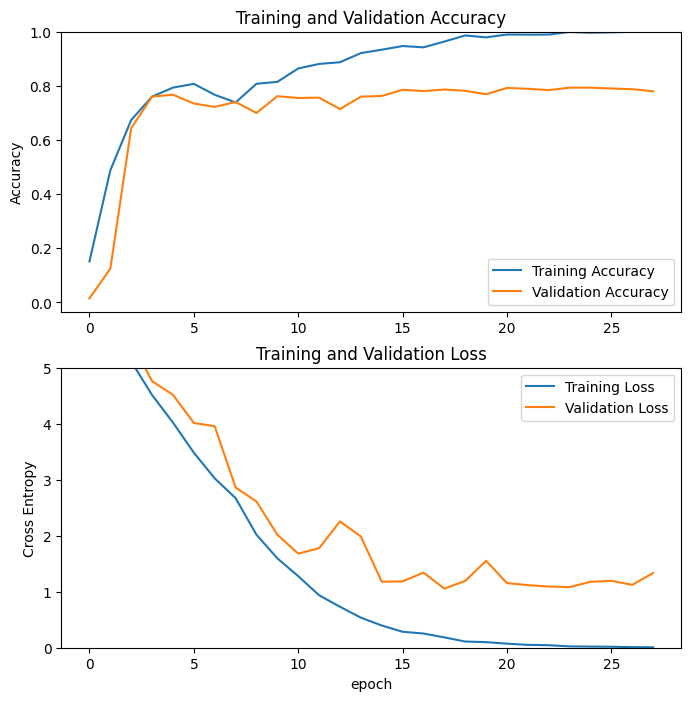

In [ ]:
# @title Learning Curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# @title Performance Metric
val_result = tl_model.evaluate(validation_data)
print("Validation Loss:", val_result[0])
print("Validation Accuracy:", val_result[1])
print("Validation Recall:", val_result[2])
print("Validation Precision:", val_result[3])
print("Validation F1 Score:", val_result[4])

181/181 [==============================] - 9s 52ms/step - loss: 1.0560 - accuracy: 0.7864 - recall: 0.7735 - precision: 0.8023 - f1_score: 0.7872
Validation Loss: 1.0559567213058472
Validation Accuracy: 0.7864077687263489
Validation Recall: 0.7734806537628174
Validation Precision: 0.8022890090942383
Validation F1 Score: 0.7871526479721069


In [ ]:
class_names_unique = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(class_names_unique)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
# @title Classification Report
from sklearn.metrics import classification_report
# Make predictions on the validation dataset
predictions_val = tl_model.predict(validation_data)
predicted_labels_val = np.argmax(predictions_val, axis=1)
true_labels_val = []
# Collect true labels from the test dataset
for images, labels in validation_data:
    true_labels_val.extend(labels.numpy())  # Extract true labels directly

true_labels_val = np.argmax(true_labels_val, axis=1)
# Assuming class_names is a list containing the class labels
target_names = class_names_unique

# Replace true_labels_test and predictions_labels_test with your actual data
print(classification_report(true_labels_val, predicted_labels_val, target_names=target_names, zero_division=0))


181/181 [==============================] - 10s 50ms/step
              precision    recall  f1-score   support

       akiec       0.67      0.34      0.45        91
         bcc       0.75      0.51      0.61       149
         bkl       0.51      0.58      0.54       281
          df       0.71      0.40      0.51        30
         mel       0.68      0.29      0.41       361
          nv       0.84      0.96      0.89      1929
        vasc       0.83      0.79      0.81        43

    accuracy                           0.79      2884
   macro avg       0.71      0.55      0.60      2884
weighted avg       0.77      0.79      0.77      2884



### Test set

In [ ]:
# @title Performance Metric
test_result = tl_model.evaluate(test_data)
print("Test Loss:", test_result[0])
print("Test Accuracy:", test_result[1])
print("Test Recall:", test_result[2])
print("Test Precision:", test_result[3])
print("Test F1 Score:", test_result[4])

126/126 [==============================] - 7s 52ms/step - loss: 1.0148 - accuracy: 0.7988 - recall: 0.7892 - precision: 0.8114 - f1_score: 0.7995
Test Loss: 1.0148215293884277
Test Accuracy: 0.7988017797470093
Test Recall: 0.7891865372657776
Test Precision: 0.8114310503005981
Test F1 Score: 0.7995308637619019


In [ ]:
# @title Classification Report
from sklearn.metrics import classification_report
predictions_test = tl_model.predict(test_data, verbose=1)
predictions_labels_test = np.argmax(predictions_test, axis=1)
true_labels_test = []
# Collect true labels from the test dataset
for images, labels in test_data:
    true_labels_test.extend(labels.numpy())  # Extract true labels directly

true_labels_test = np.argmax(true_labels_test, axis=1)

# Assuming class_names is a list containing the class labels
target_names = class_names_unique

# Replace true_labels_test and predictions_labels_test with your actual data
print(classification_report(true_labels_test, predictions_labels_test, target_names=target_names, zero_division=0))


126/126 [==============================] - 6s 51ms/step
              precision    recall  f1-score   support

       akiec       0.70      0.40      0.51        70
         bcc       0.68      0.57      0.62        94
         bkl       0.57      0.65      0.61       226
          df       0.53      0.50      0.51        20
         mel       0.63      0.33      0.44       223
          nv       0.86      0.95      0.90      1338
        vasc       0.91      0.66      0.76        32

    accuracy                           0.80      2003
   macro avg       0.70      0.58      0.62      2003
weighted avg       0.79      0.80      0.78      2003



Normalized confusion matrix


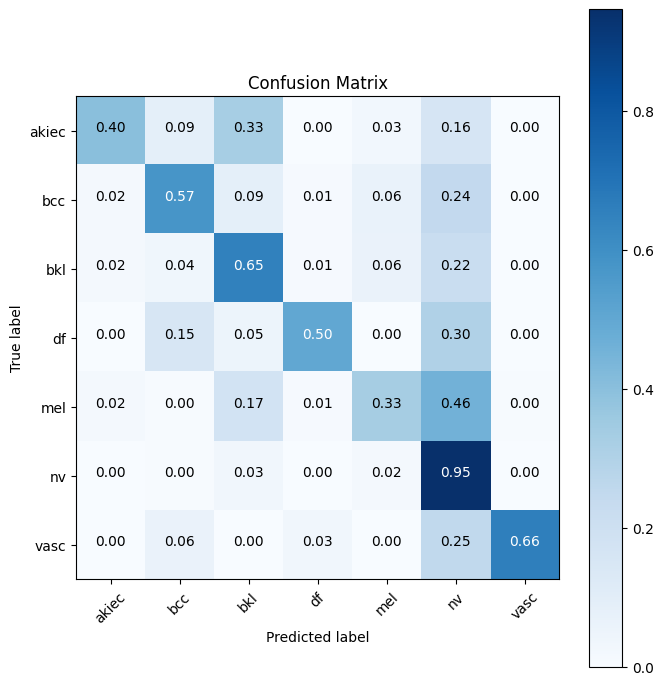

In [ ]:
# @title Confusion Matrix
import itertools
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(true_labels_test, predictions_labels_test)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_labels = test_ds_original.class_names
#cm_plot_labels = list(df_labels[label.numpy().tolist()[0]])
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

### Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/"resnet"

# Save model

In [ ]:
version = "vit-version-v2"

In [ ]:
# Define the local directory to save TensorBoard logs
local_logdir = f"/content/drive/MyDrive/FYP/models with log/log/ResNet50/latest/{version}"

# Copy the contents of the log directory to the local directory
# Check if the file exists
if os.path.exists(local_logdir):
    print("Error: A log with the same file name already exists. Log not saved.")
else:
    # Save the log
    shutil.copytree(logdir, local_logdir)
    print("Log saved successfully")

Log saved successfully


In [ ]:
import os

saved_model_path = f"/content/drive/MyDrive/FYP/models with log/models/ResNet50/latest/{version}"

# Check if the file exists
if os.path.exists(saved_model_path):
    print("Error: A model with the same file name already exists. Model not saved.")
else:
    # Save the model
    tf.saved_model.save(tl_model, saved_model_path)
    print("Model saved successfully.")


Model saved successfully.
